In [1]:
# from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist, cifar100

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GT 650M (0000:01:00.0)


In [77]:
#train vae model on mnist data
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

image_dim = x_train[0].shape
original_dim = np.prod(image_dim)
latent_dim = 2
# intermediate_dims = np.array([2512, 1256, 512])
intermediate_dims = np.array([256])

nb_epoch = 5
batch_size = 1
epsilon_std = 1.0e-0

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [78]:
##use the sampled latent points to generate new latent points z in the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

#custom loss function
def vae_loss(x, x_decoded_mean):
    #cross entropy term
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    #KL-divergence tmer
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    #sum both terms
    return xent_loss + kl_loss


In [79]:
##encoder network to map real inputs to latent space
x = Input(batch_shape=(batch_size, original_dim))

h = [x]
for i in range(len(intermediate_dims)):
    h.append(Dense(intermediate_dims[i], activation='relu')(h[i]))
# h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h[-1])
z_log_var = Dense(latent_dim)(h[-1])

In [80]:
#generate latent points (lambda function layer)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [81]:
##map sampled latent points back to reconstructed points
# we instantiate these layers separately so as to reuse them later

# decoder_h = Dense(intermediate_dim, activation='relu')
# h_decoded = decoder_h(z)

h_decoded = []
for i in range(len(intermediate_dims)):
    h_decoded.append(Dense(intermediate_dims[-1-i], activation='relu'))

decoder_mean = Dense(original_dim, activation='sigmoid')
# x_decoded_mean = decoder_mean(h_decoded)


In [82]:
def h_apply(h_l, x):
#     y = [x]
#     for i in range(len(h_l)):
#         y.append(h_l[i](y[i]))
#     return y[-1]
    y = [x]
    for h in h_l:
        y = h(y)
    return y
x_decoded_mean = decoder_mean(h_apply(h_decoded, z))

In [83]:
'''
So far we have generated three models
'''

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

#compile vae model
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [84]:
##train model
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 187s - loss: 1926.1964 - val_loss: 1916.5788

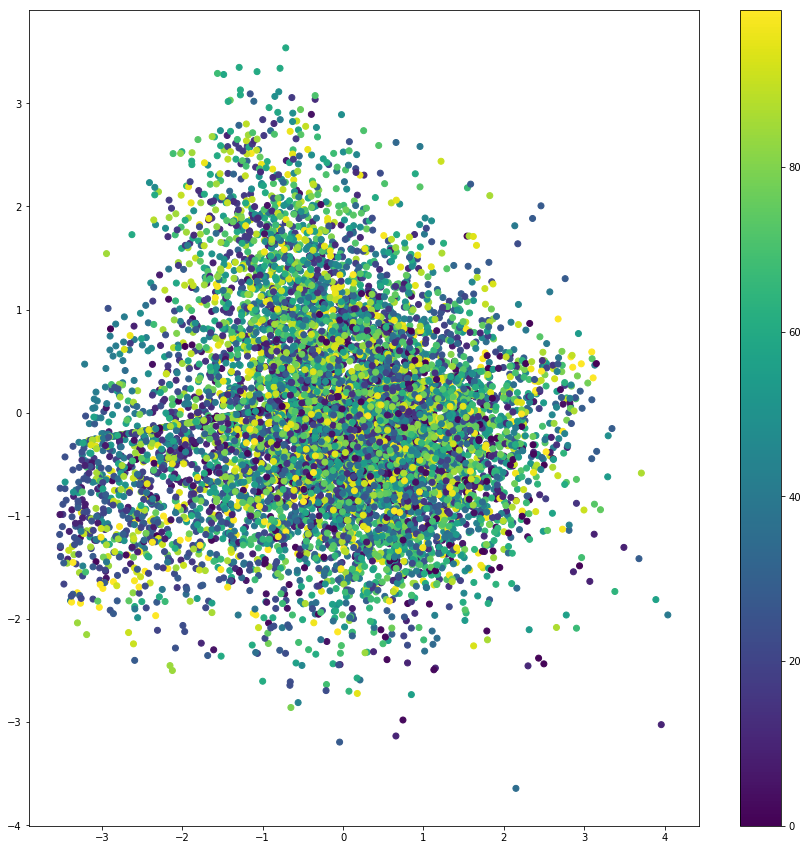

In [85]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(15, 15))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [86]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
# _h_decoded = decoder_h(decoder_input)
# _x_decoded_mean = decoder_mean(_h_decoded)
_x_decoded_mean = decoder_mean(h_apply(h_decoded, decoder_input))
generator = Model(decoder_input, _x_decoded_mean)

In [87]:
from PIL import Image

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
disp_size = np.array(image_dim)
digit_size = image_dim[-1]
disp_size[-2] = n * digit_size
disp_size[-1] = n * digit_size

figure = np.zeros(tuple(disp_size))

# we will sample n points within [-m, m] standard deviations
m = 1 * epsilon_std
grid_x = np.linspace(-m, m, n)
grid_y = np.linspace(-m, m, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded.reshape(image_dim)
        figure[:, i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# print a
# plt.figure(figsize=(10, 10))
# plt.imshow(figure)
# plt.show()
figure = np.uint8(figure * 255)
if figure.ndim > 2:
#     figure = np.swapaxes(figure, 0, figure.ndim -1)
    for i in range(figure.ndim - 1):
        figure = np.swapaxes(figure, i, i+1)
img = Image.fromarray(figure)
img.show()

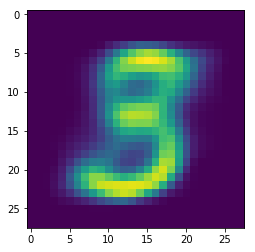

In [12]:
z_sample = np.array([[0, 0]]) * epsilon_std
x_decoded = generator.predict(z_sample)
plt.imshow(x_decoded.reshape(28, 28))
plt.show()